In [4]:
import os
import sqlite3
import pprint
from datetime import datetime
import pandas as pd 

date_format = "%Y-%m-%d %H:%M:%S.%f"
failure_list = ["dependency", "divide_zero", "environment", "manager_kill", "memory", "node_kill", "ulimit", "worker_kill"]

def get_failure_type(workflow_cnt, repeat=10):
    i = workflow_cnt//repeat
    if i >= len(failure_list):
        return "unknown"
    else:
        return failure_list[i]
    
def sorted_walk(top):
    for root, dirs, files in os.walk(top):
        dirs.sort()
        yield root, dirs, files

def process_workflow(runs_directory):
    workflow_list = []
    
    for root, dirs, files in sorted_walk(runs_directory):
        if 'monitoring.db' in files:
            info = {}
            db_path = os.path.join(root, 'monitoring.db')
            try:
                conn = sqlite3.connect(db_path)
                cursor = conn.cursor()

                info['db_dir'] = db_path

                # get run_id
                cursor.execute("SELECT run_id FROM workflow")
                rows = cursor.fetchall()
                info['run_id'] = rows[0][0]

                # get failure type
                info['failure_type'] = get_failure_type(len(workflow_list))

                # get success or not
                cursor.execute("SELECT task_fail_history FROM try WHERE task_id IS 5")
                rows = cursor.fetchall()
                info['success'] = False
                if len(rows) > 0:
                    for row in rows:
                        if row[0] == "":
                            info['success'] = True
                            break

                # get total time
                cursor.execute("SELECT task_try_time_returned, task_try_time_launched FROM try")
                rows = cursor.fetchall()
                
                total_time = 0
                for row in rows:
                    task_time_return = row[0]
                    task_time_launch = row[1]
                    if task_time_return is not None and task_time_launch is not None:
                        return_object = datetime.strptime(task_time_return, date_format)
                        return_timestamp = return_object.timestamp()
                        invoke_object = datetime.strptime(task_time_launch, date_format)
                        invoke_timestamp = invoke_object.timestamp()
                        total_time += return_timestamp - invoke_timestamp
                
                info['total_time'] = total_time

                # get number of try
                cursor.execute("SELECT task_fail_history FROM try")
                rows = cursor.fetchall()
                info['try_time'] = len(rows)
                
                conn.close()
            except sqlite3.Error as e:
                print(f"Error reading {db_path}: {e}")
            finally:
                workflow_list.append(info)
    
    return workflow_list



In [5]:
plain_list = process_workflow('without')
plain_df = pd.DataFrame(plain_list)

conn = sqlite3.connect('result.db')
table_name = "without_time"
plain_df.to_sql(table_name, conn, if_exists='replace', index=False)

plain_df

,db_dir,run_id,failure_type,success,total_time,try_time
0,without/failure-injection-2024-06-20-13-05-52/...,789f42d8-eeb8-494d-80a4-98ef59160cef,dependency,True,626.956709,6
1,without/failure-injection-2024-06-20-13-08-38/...,95bb5275-5eb7-4d2a-8e53-d37980bd73b1,dependency,True,57.383083,8
2,without/failure-injection-2024-06-20-13-09-03/...,04cb6f4d-1144-4aa3-a7fb-19b82aa6000d,dependency,True,163.139766,7
3,without/failure-injection-2024-06-20-13-09-45/...,3eb0bcd1-4b1a-41b7-82a8-f09e0c5bcdb0,dependency,True,587.903465,6
4,without/failure-injection-2024-06-20-13-11-50/...,74ab6eed-41bc-4cda-a70a-90adcb96fad6,dependency,True,289.024363,9
...,...,...,...,...,...,...
75,without/failure-injection-2024-06-20-15-18-53/...,a66e3099-04f7-40e3-9ade-f6b667c1782a,worker_kill,True,281.282539,6
76,without/failure-injection-2024-06-20-15-19-57/...,6649d6e7-50ed-4f03-8878-14ac4c6caca9,worker_kill,True,276.237550,6
77,without/failure-injection-2024-06-20-15-20-59/...,99a3866f-6b46-4a00-adc8-6e628dbf7682,worker_kill,True,276.774761,6
78,without/failure-injection-2024-06-20-15-22-01/...,09ad791a-91fd-491d-afa2-dae90d7987b2,worker_kill,True,275.519912,6


In [6]:
retry_list = process_workflow('with')
retry_df = pd.DataFrame(retry_list)

table_name = "with_time"
retry_df.to_sql(table_name, conn, if_exists='replace', index=False)

retry_df

,db_dir,run_id,failure_type,success,total_time,try_time
0,with/failure-injection-2024-06-20-10-52-35/par...,b58f36ab-c717-4410-a47a-d133373bf9ce,dependency,True,34.987287,6
1,with/failure-injection-2024-06-20-10-52-53/par...,d1e772bf-ba0d-4248-bd7c-af602437e105,dependency,True,30.624780,6
2,with/failure-injection-2024-06-20-10-53-07/par...,8811d0ae-1abe-40ef-9d0c-a2a0527143a7,dependency,True,30.234914,6
3,with/failure-injection-2024-06-20-10-53-21/par...,29f71304-9cfa-42b1-9c4e-82817d4a3219,dependency,False,52.423509,5
4,with/failure-injection-2024-06-20-10-53-40/par...,a69881fe-4552-4dee-942c-b9fb97148908,dependency,True,26.673800,6
...,...,...,...,...,...,...
75,with/failure-injection-2024-06-20-12-57-55/par...,fdb8cc8d-abc8-4d3e-9f87-de935aca0aa0,worker_kill,True,262.727383,6
76,with/failure-injection-2024-06-20-12-58-56/par...,326fb5b1-509b-4c07-9d48-d6d73bc2b7e8,worker_kill,True,35.811916,6
77,with/failure-injection-2024-06-20-12-59-09/par...,f66cc88f-d234-4143-b63e-658f3e536a69,worker_kill,True,193.553443,6
78,with/failure-injection-2024-06-20-12-59-55/par...,ad24b898-6a94-47e2-9474-be2b8a32c830,worker_kill,True,76.693938,6


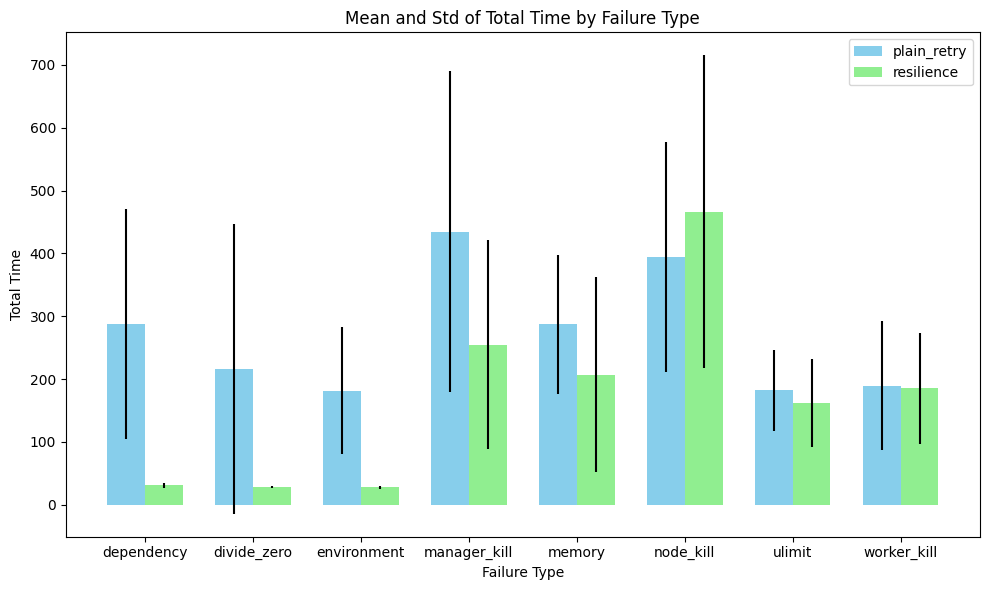

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 计算均值和方差
stats_df1 = plain_df.groupby('failure_type')['total_time'].agg(['mean', 'std']).reset_index()
filtered_retry_df = retry_df[retry_df['success'] == True]
stats_df2 = filtered_retry_df.groupby('failure_type')['total_time'].agg(['mean', 'std']).reset_index()

# 合并两个DataFrame
merged_stats = pd.merge(stats_df1, stats_df2, on='failure_type', suffixes=('_df1', '_df2'))

# 设置柱状图位置
x = np.arange(len(merged_stats['failure_type']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制df1的柱状图
rects1 = ax.bar(x - width/2, merged_stats['mean_df1'], width, yerr=merged_stats['std_df1'], label='plain_retry', color='skyblue')

# 绘制df2的柱状图
rects2 = ax.bar(x + width/2, merged_stats['mean_df2'], width, yerr=merged_stats['std_df2'], label='resilience', color='lightgreen')

# 添加一些文本用于标签、标题和自定义x轴刻度
ax.set_xlabel('Failure Type')
ax.set_ylabel('Total Time')
ax.set_title('Mean and Std of Total Time by Failure Type')
ax.set_xticks(x)
ax.set_xticklabels(merged_stats['failure_type'])
ax.legend()

# 自动调整标签
fig.tight_layout()

# 显示图形
plt.show()
